In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

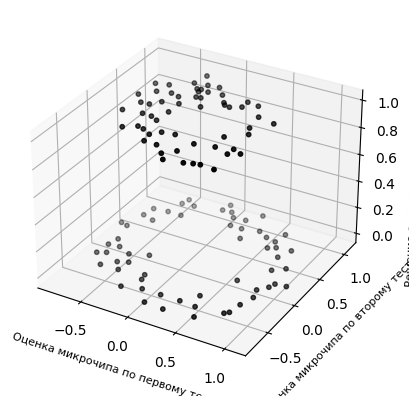

In [ ]:
# 3.1 визуализация данных

path = 'ex2data2.txt'
df = pd.read_csv(path, header=None,
                 names=['Оценка микрочипа по первому тесту', 'Оценка микрочипа по второму тесту', 'Решение о соответствии характеристикам'])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df['Оценка микрочипа по первому тесту'], df['Оценка микрочипа по второму тесту'], df['Решение о соответствии характеристикам'], c='black', s=10)
ax.set_xlabel('Оценка микрочипа по первому тесту', fontsize=8)
ax.set_ylabel('Оценка микрочипа по второму тесту', fontsize=8)
ax.set_zlabel('Решение о соответствии характеристикам', fontsize=8)

plt.show()

In [ ]:
# 3.2 создание вектора признаков

# задание матрицы X0 (первый столбец содержит единицы, второй и третий - признаки)
X0 = np.ones((df['Оценка микрочипа по первому тесту'].size, 3))
X0[:, 1] = df['Оценка микрочипа по первому тесту'].values
X0[:, 2] = df['Оценка микрочипа по второму тесту'].values

# вектор выходных данных
y = np.array(df['Решение о соответствии характеристикам']).reshape(-1, 1)

max_degree = 30
X_strike = np.column_stack([X0[:, 1] ** i * X0[:, 2] ** (degree - i)
                            for degree in range(max_degree + 1)
                            for i in range(degree + 1)])

In [ ]:
# 3.3 разбиение данных на тренировочный, кроссвалидационный и тестовый наборы данных

idx = np.arange(len(X_strike))
np.random.shuffle(idx)

split_idx1 = int(0.6 * len(X_strike))
split_idx2 = int(0.8 * len(X_strike))

X_train, X_cv, X_test = X_strike[idx[:split_idx1]], X_strike[idx[split_idx1:split_idx2]], X_strike[idx[split_idx2:]]
y_train, y_cv, y_test = y[idx[:split_idx1]], y[idx[split_idx1:split_idx2]], y[idx[split_idx2:]]

In [ ]:
# задание гипотезы


def g(z):
    return np.exp(z) / (1 + np.exp(z))


def h_θ(θ, X):
    return g(np.dot(X, θ))

In [ ]:
# 3.4 реализация регуляризованной функции потерь

ε = 1e-4


def L(θ, λ, X, y):
    loss = 0

    for i in range(X.shape[0]):
        loss -= (y[i, 0] * np.log(h_θ(θ, X[i]) + ε) + (1 - y[i, 0]) * np.log(1 - h_θ(θ, X[i]) + ε)) / X.shape[0]

    for i in range(X.shape[1]):
        loss += λ * θ[i] ** 2 / (2 * X.shape[0])

    return loss

In [ ]:
# задание скорости обучения
α = 0.5

# задание числа итераций
iterations_num = 5000

In [ ]:
# 3.5 реализация градиентного спуска с регуляризацией

def grad(θ, λ, X, y):
    grad = np.zeros(X.shape[1])

    for i in range(X.shape[0]):
        grad += (h_θ(θ, X[i]) - y[i, 0]) * X[i]

    grad += θ * λ

    return grad

In [ ]:
# 3.6 обучение и выбор того значения параметра регуляризации, при котором обученная модель достигает минимального значения функции потерь (нерегуляризованной!) на кроссвалидационной выборке

def train_model(X_train, y_train, X_cv, y_cv, reg_param_range, reg_param_step):

    min_loss = float('inf')
    min_reg_param = 0.0

    for reg_param in np.arange(reg_param_range[0], reg_param_range[1], reg_param_step):
        loss = []
        theta_updated = np.zeros(X_train.shape[1])

        for i in range(iterations_num):
            loss.append(L(theta_updated, reg_param, X_train, y_train))
            theta_updated -= α / X_train.shape[0] * grad(theta_updated, reg_param, X_train, y_train)

        cv_loss = L(theta_updated, 0.0, X_cv, y_cv)

        if cv_loss < min_loss:
            min_loss = cv_loss
            min_reg_param = reg_param
            theta = theta_updated

    return min_reg_param, theta

In [ ]:
reg_param_range = (0, 0.5)
reg_param_step = 0.05

min_reg_param, theta = train_model(X_train, y_train, X_cv, y_cv, reg_param_range, reg_param_step)

print(f"The minimum loss on the cross-validation set is achieved for reg_param = {min_reg_param:.2f}")

The minimum loss on the cross-validation set is achieved for reg_param = 0.35


In [ ]:
# 3.7 расчет точности на тренировочной, кроссвалидационной и тестовой выборках
# сравнение того, как изменились точности с регуляризацией и без нее.

# точность = (количество правильно классифицированных примеров) / (размер выборки)

y_pred_train_with = np.round(h_θ(theta, X_train))
num_correct = 0
for i in range(len(y_train)):
    if y_pred_train_with[i] == y_train[i]:
        num_correct += 1

accuracy = num_correct / X_train.shape[0]
print('точность на тренировочной выборке с регуляризацией: ', accuracy)

точность на тренировочной выборке с регуляризацией:  0.8428571428571429


In [ ]:
y_pred_cv_with = np.round(h_θ(theta, X_cv))
num_correct = 0
for i in range(len(y_cv)):
    if y_pred_cv_with[i] == y_cv[i]:
        num_correct += 1

accuracy = num_correct / X_cv.shape[0]
print('точность на кроссвалидационной выборке с регуляризацией: ', accuracy)

точность на кроссвалидационной выборке с регуляризацией:  0.7083333333333334


In [ ]:
y_pred_test_with = np.round(h_θ(theta, X_test))
num_correct = 0
for i in range(len(y_test)):
    if y_pred_test_with[i] == y_test[i]:
        num_correct += 1

accuracy = num_correct / X_test.shape[0]
print('точность на тестовой выборке с регуляризацией: ', accuracy)

точность на тестовой выборке с регуляризацией:  0.7916666666666666
